In [1]:
import os, sys, time, copy
import numpy as np
import matplotlib.pyplot as plt
import pickle
import myokit
sys.path.append('../')
sys.path.append('../Protocols')
sys.path.append('../Models')
sys.path.append('../Lib')
import protocol_lib, vc_protocols
import mod_trace
from ord2011 import ORD2011

In [2]:
'''
O'Hara-Rudy CiPA v1.0 (2011)
'''
cells = {
    'Endocardial' : 0,
    'Epicardial' : 1,
    'Mid-myocardial' : 2,
}
current_li = ['I_Na', 'I_NaL', 'I_to', 'I_CaL', 'I_Kr', 'I_Ks', 'I_K1' ]         
# protocol = vc_protocols.hERG_CiPA()
protocol = pickle.load(open("./trial_steps_ramps_Kernik_200_50_4_-120_60_paper/shortened_trial_steps_ramps_Kernik_200_50_4_-120_60_500_artefact_True_short.pkl", 'rb'))
# protocol = pickle.load(open("./trial_steps_ramps_ORD2011_288_51_4_-121_61/shortened_trial_steps_ramps_ORD2011_288_51_4_-121_61_500_artefact_False_short.pkl", 'rb'))

end_time = protocol.get_voltage_change_endpoints()[-1]
t_span = (0, end_time)
t_eval = np.linspace(0, end_time, 20000)
print(end_time)

9055.950603217367


In [3]:
start_time = time.time()

import simulator_myokit
'''
Simulation with Myokit
'''
model_path = "../mmt-model-files/ord-2011_VC.mmt" 
model_myokit, protocol_myokit, script = myokit.load(model_path)
sim_myokit = simulator_myokit.Simulator(model_myokit, protocol, max_step=1.0, abs_tol=1e-8, rel_tol=1e-8, vhold=-80.0)  # 1e-12, 1e-14  # 1e-08, 1e-10
sim_myokit.name = "ORD2011"

sim_myokit.simulation.set_constant('cell.mode', cells['Epicardial'])    
# y0_myokit = sim_myokit.pre_simulate(5000, sim_type=1)
d_myokit = sim_myokit.simulate(end_time, log_times=None, extra_log=['ina.INa', 'inal.INaL', 'ito.Ito', 'ical.ICaL', 'ikr.IKr', 'iks.IKs', 'ik1.IK1'])
myokit_current_response_info = mod_trace.CurrentResponseInfo(protocol)
for i, t in enumerate(d_myokit['engine.time']):    
    current_timestep = [                
        mod_trace.Current(name='I_Na', value=d_myokit['ina.INa'][i]),
        mod_trace.Current(name='I_NaL', value=d_myokit['inal.INaL'][i]),                
        mod_trace.Current(name='I_to', value=d_myokit['ito.Ito'][i]),
        mod_trace.Current(name='I_CaL', value=d_myokit['ical.ICaL'][i]),
        mod_trace.Current(name='I_Kr', value=d_myokit['ikr.IKr'][i]),
        mod_trace.Current(name='I_Ks', value=d_myokit['iks.IKs'][i]),
        mod_trace.Current(name='I_K1', value=d_myokit['ik1.IK1'][i]),
    ]
    myokit_current_response_info.currents.append(current_timestep)

print("--- %s seconds ---"%(time.time()-start_time))

--- 3.6341161727905273 seconds ---


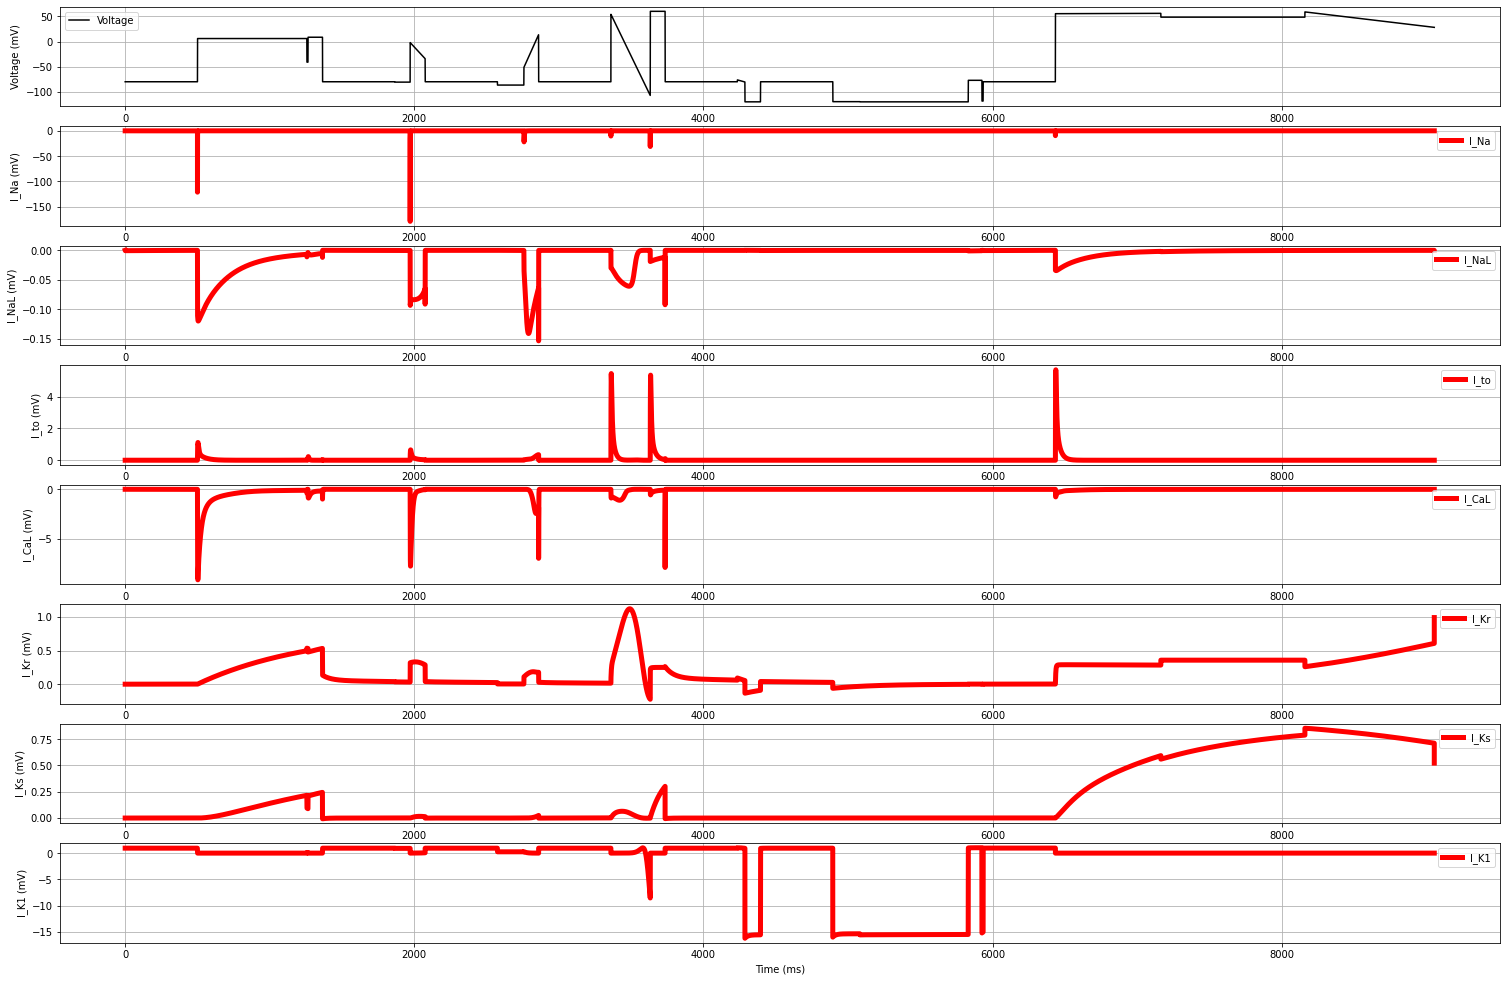

In [4]:
'''
Plot
'''
fig, axes = plt.subplots(8,1, figsize=(20,20))    
# fig.suptitle(model_scipy.name, fontsize=14)
plot_li = ['Voltage'] + current_li
for i, name in enumerate(plot_li):    
    # ax.set_title('Simulation %d'%(simulationNo))
    # axes[i].set_xlim(model_scipy.times.min(), model_scipy.times.max())
    # ax.set_ylim(ylim[0], ylim[1])
    axes[i].set_xlabel('Time (ms)')       
    axes[i].set_ylabel(f'{name} (mV)')  
    
    if i==0:
        axes[i].plot( t_eval, [protocol.get_voltage_at_time(t) for t in t_eval], label=name, color='k')           
    else:
        axes[i].plot( d_myokit['engine.time'], myokit_current_response_info.get_current([name]), label=name, color='r', linewidth=5) 
#         axes[i].plot( sol_scipy.t, model_scipy.current_response_info.get_current([name]), label=name, color='k')   
    axes[i].legend()
    axes[i].grid()

plt.subplots_adjust(left=0.0, bottom=0.3, right=1.0, top=0.95, wspace=0.5, hspace=0.2)
plt.show()
fig.savefig(os.path.join('Results', "ORD2011-VC"), dpi=100)

In [5]:
start_time = time.time()
protocol = vc_protocols.hERG_CiPA()
sim_myokit.reset_simulation_with_new_protocol( protocol)

sim_myokit.simulation.set_constant('cell.mode', cells['Epicardial'])    
y0_myokit = sim_myokit.pre_simulate(5000, sim_type=1)
d_myokit = sim_myokit.simulate(1000, log_times=None, extra_log=['ina.INa', 'inal.INaL', 'ito.Ito', 'ical.ICaL', 'ikr.IKr', 'iks.IKs', 'ik1.IK1'])
myokit_current_response_info = mod_trace.CurrentResponseInfo(protocol)
for i, t in enumerate(d_myokit['engine.time']):    
    current_timestep = [                
        mod_trace.Current(name='I_Na', value=d_myokit['ina.INa'][i]),
        mod_trace.Current(name='I_NaL', value=d_myokit['inal.INaL'][i]),                
        mod_trace.Current(name='I_to', value=d_myokit['ito.Ito'][i]),
        mod_trace.Current(name='I_CaL', value=d_myokit['ical.ICaL'][i]),
        mod_trace.Current(name='I_Kr', value=d_myokit['ikr.IKr'][i]),
        mod_trace.Current(name='I_Ks', value=d_myokit['iks.IKs'][i]),
        mod_trace.Current(name='I_K1', value=d_myokit['ik1.IK1'][i]),
    ]
    myokit_current_response_info.currents.append(current_timestep)

print("--- %s seconds ---"%(time.time()-start_time))

--- 1.5565283298492432 seconds ---


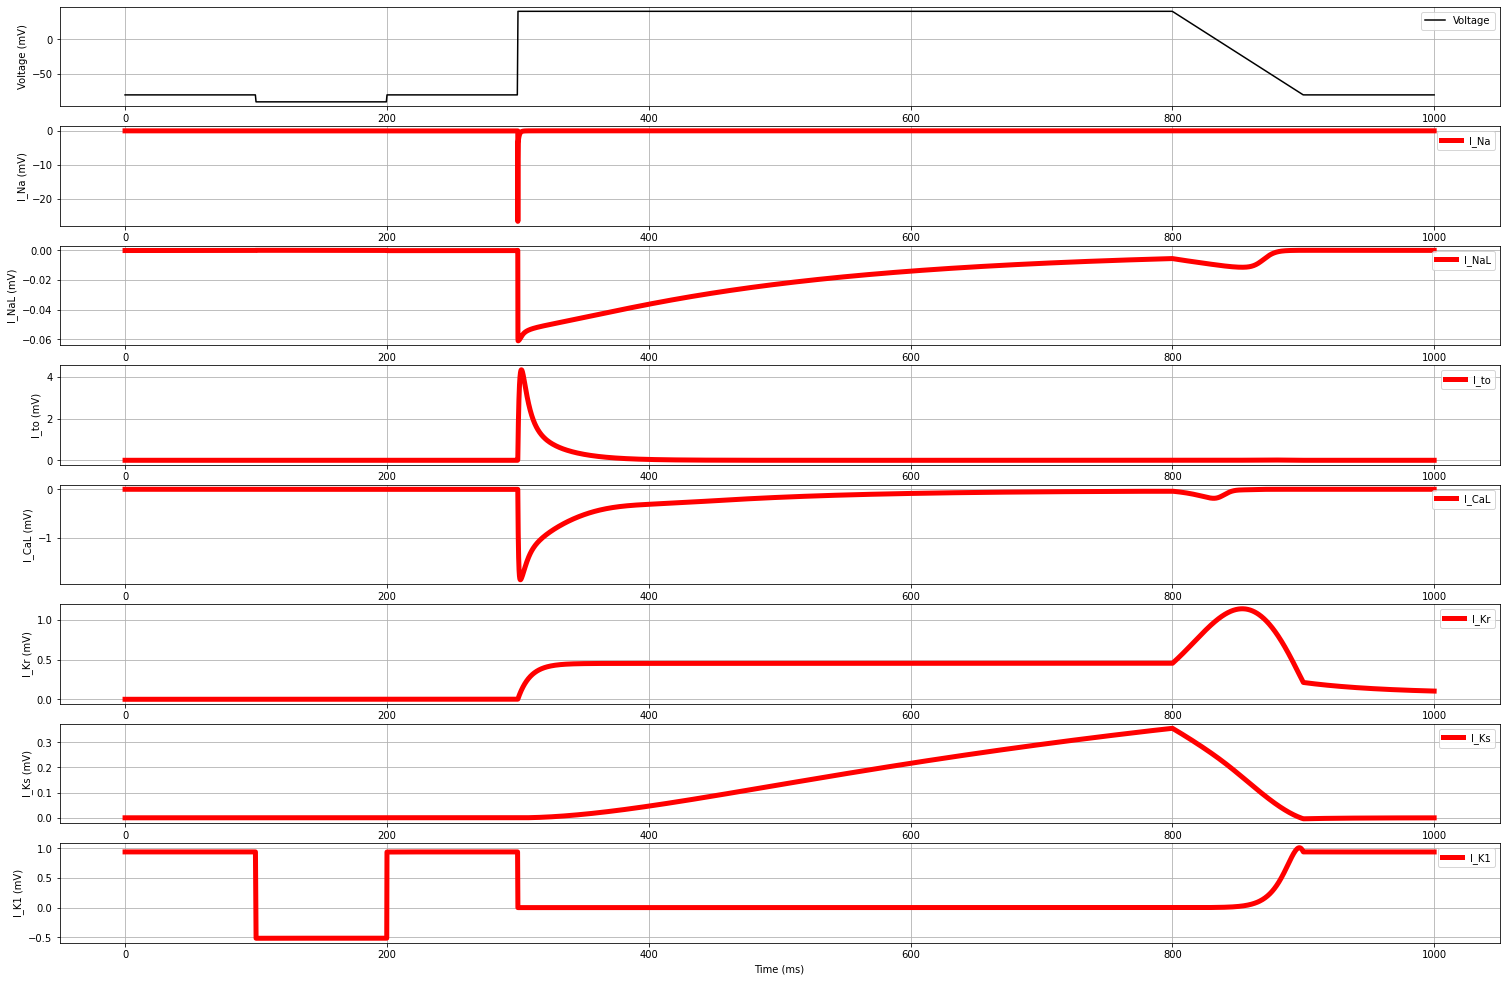

In [6]:
'''
Plot
'''
fig, axes = plt.subplots(8,1, figsize=(20,20))    
# fig.suptitle(model_scipy.name, fontsize=14)
plot_li = ['Voltage'] + current_li
for i, name in enumerate(plot_li):    
    # ax.set_title('Simulation %d'%(simulationNo))
    # axes[i].set_xlim(model_scipy.times.min(), model_scipy.times.max())
    # ax.set_ylim(ylim[0], ylim[1])
    axes[i].set_xlabel('Time (ms)')       
    axes[i].set_ylabel(f'{name} (mV)')  
    
    if i==0:
        axes[i].plot( np.linspace(0,1000,2000), [protocol.get_voltage_at_time(t) for t in np.linspace(0,1000,2000)], label=name, color='k')           
    else:
        axes[i].plot( d_myokit['engine.time'], myokit_current_response_info.get_current([name]), label=name, color='r', linewidth=5) 
#         axes[i].plot( sol_scipy.t, model_scipy.current_response_info.get_current([name]), label=name, color='k')   
    axes[i].legend()
    axes[i].grid()

plt.subplots_adjust(left=0.0, bottom=0.3, right=1.0, top=0.95, wspace=0.5, hspace=0.2)
plt.show()
fig.savefig(os.path.join('Results', "ORD2011-VC"), dpi=100)

In [7]:
import simulator_myokit
'''
Simulation with Myokit
'''

start_time = time.time()
model_path = "../mmt-model-files/ord-2011_VC.mmt" 
model_myokit, protocol_myokit, script = myokit.load(model_path)
protocol = vc_protocols.hERG_CiPA()
sim_myokit = simulator_myokit.Simulator(model_myokit, protocol, max_step=1.0, abs_tol=1e-8, rel_tol=1e-10, vhold=-80.0)  # 1e-12, 1e-14  # 1e-08, 1e-10
sim_myokit.simulation.set_constant('cell.mode', cells['Epicardial'])    
y0_myokit = sim_myokit.pre_simulate(5000, sim_type=1)
d_myokit = sim_myokit.simulate(1000, log_times=None, extra_log=['ina.INa', 'inal.INaL', 'ito.Ito', 'ical.ICaL', 'ikr.IKr', 'iks.IKs', 'ik1.IK1'])
myokit_current_response_info = mod_trace.CurrentResponseInfo(protocol)
for i, t in enumerate(d_myokit['engine.time']):    
    current_timestep = [                
        mod_trace.Current(name='I_Na', value=d_myokit['ina.INa'][i]),
        mod_trace.Current(name='I_NaL', value=d_myokit['inal.INaL'][i]),                
        mod_trace.Current(name='I_to', value=d_myokit['ito.Ito'][i]),
        mod_trace.Current(name='I_CaL', value=d_myokit['ical.ICaL'][i]),
        mod_trace.Current(name='I_Kr', value=d_myokit['ikr.IKr'][i]),
        mod_trace.Current(name='I_Ks', value=d_myokit['iks.IKs'][i]),
        mod_trace.Current(name='I_K1', value=d_myokit['ik1.IK1'][i]),
    ]
    myokit_current_response_info.currents.append(current_timestep)

print("--- %s seconds ---"%(time.time()-start_time))

'''
Plot
'''
fig, axes = plt.subplots(8,1, figsize=(20,20))    
# fig.suptitle(model_scipy.name, fontsize=14)
plot_li = ['Voltage'] + current_li
for i, name in enumerate(plot_li):    
    # ax.set_title('Simulation %d'%(simulationNo))
    # axes[i].set_xlim(model_scipy.times.min(), model_scipy.times.max())
    # ax.set_ylim(ylim[0], ylim[1])
    axes[i].set_xlabel('Time (ms)')       
    axes[i].set_ylabel(f'{name} (mV)')  
    
    if i==0:
        axes[i].plot( np.linspace(0,1000,2000), [protocol.get_voltage_at_time(t) for t in np.linspace(0,1000,2000)], label=name, color='k')           
    else:
        axes[i].plot( d_myokit['engine.time'], myokit_current_response_info.get_current([name]), label=name, color='r', linewidth=5) 
#         axes[i].plot( sol_scipy.t, model_scipy.current_response_info.get_current([name]), label=name, color='k')   
    axes[i].legend()
    axes[i].grid()

plt.subplots_adjust(left=0.0, bottom=0.3, right=1.0, top=0.95, wspace=0.5, hspace=0.2)
plt.show()
fig.savefig(os.path.join('Results', "ORD2011-VC"), dpi=100)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_166779/2862056826.py", line 22, in <module>
    mod_trace.Current(name='I_Ks', value=d_myokit['iks.IKs'][i]),
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/opt/conda/lib/python3.7/site-pac

TypeError: object of type 'NoneType' has no len()